In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses

In [5]:
image_data = tf.keras.datasets.cifar10

In [6]:
(train_img, train_labels), (test_img, test_labels) = image_data.load_data()

c:\Users\mateu\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<Figure size 800x480 with 0 Axes>

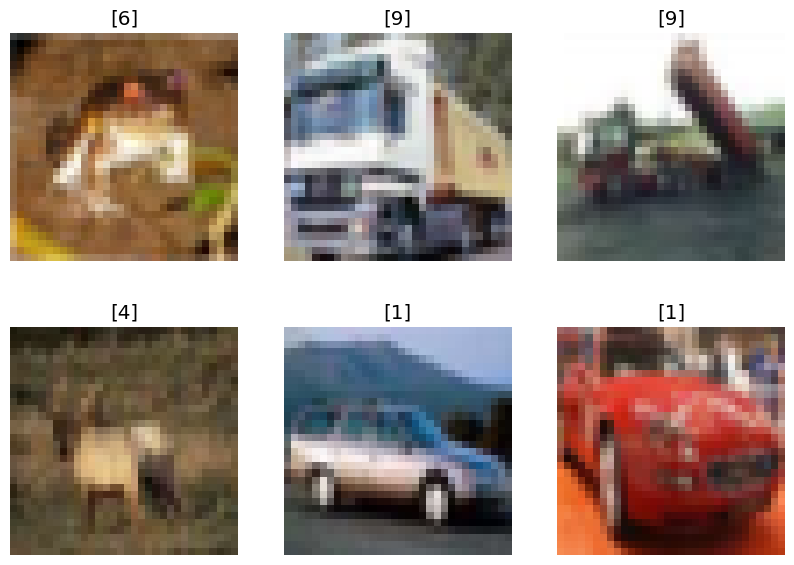

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6), dpi=80)
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 3

for i in range(6):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_img[i], cmap="gray")
    plt.axis('off')
    plt.title(train_labels[i])

In [10]:
# 1 classic - LeNet
lenet = models.Sequential()
lenet.add(layers.Conv2D(6, 5, activation='tanh', input_shape=train_img.shape[1:]))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(16, 5, activation='tanh'))
lenet.add(layers.AveragePooling2D(2))
lenet.add(layers.Activation('sigmoid'))
lenet.add(layers.Conv2D(120, 5, activation='tanh'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation='tanh'))
lenet.add(layers.Dense(10, activation='softmax'))
lenet.summary()

lenet_runtime = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

In [6]:
# 2 own model
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation="relu",input_shape=train_img.shape[1:]))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.summary()

model_runtimes = []

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)         

In [11]:
# 3 ResNet - transfer learning
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(10, activation = 'softmax')(x)
resnet = keras.Model(inputs = base_model.input, outputs = predictions)

resnet_runtimes = []
resnet.summary()

234698864/234698864 [==============================] - 206s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                         

In [12]:
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(self.epochs, self.times, 'ro')
        total = 0
        for i in range(len(self.epochs)):
          j = self.times[i].numpy()
          if i == 0:
            plt.text(i, j, str(round(j, 3)))
            total += tf.get_static_value(j)
            resnet_runtimes.append(tf.get_static_value(j))
          else:
            j_prev = self.times[i-1].numpy()
            plt.text(i, j, str(round(j-j_prev, 3)))
            total += tf.get_static_value(j-j_prev)
            resnet_runtimes.append(tf.get_static_value(j-j_prev))
        plt.savefig(datetime.now().strftime("%Y%m%d%H%M%S") + ".png")
        plt.title(str(round(total, 4)) + "s")

# LeNet classification

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 2.2238 - accuracy: 0.1464 - val_loss: 2.0556 - val_accuracy: 0.2260
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 1.9529 - accuracy: 0.2607 - val_loss: 1.8542 - val_accuracy: 0.2995
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 1.8067 - accuracy: 0.3319 - val_loss: 1.7546 - val_accuracy: 0.3560
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 1.7417 - accuracy: 0.3580 - val_loss: 1.7967 - val_accuracy: 0.3435
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 1.6961 - accuracy: 0.3742 - val_loss: 1.6679 - val_accuracy: 0.3900
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 1.6544 - accuracy: 0.3906 - val_loss: 1.6451 - val_accuracy: 0.3943
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 1.6241 - accuracy: 0.4044 - val_loss: 1.6462 - val_accuracy: 0.385

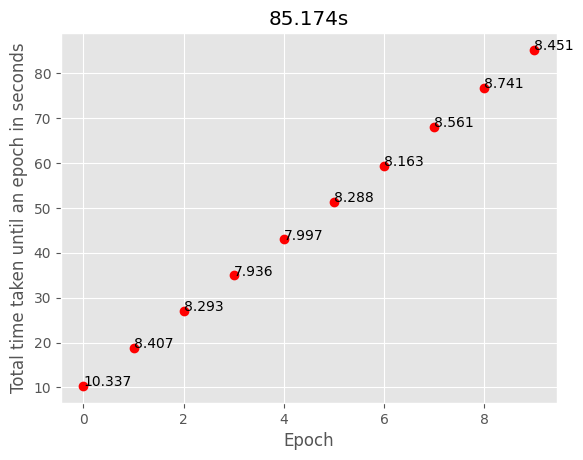

In [13]:
lenet.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
lenet_history = lenet.fit(train_img, train_labels, validation_split = 0.2, batch_size=64, epochs=10, callbacks=[timecallback()])

In [11]:
start = tf.timestamp()
lenet_eval = lenet.evaluate(test_img, test_labels, batch_size=64)
print("Seconds taken for testing: ")
print(tf.get_static_value(tf.timestamp() - start))
print("Accuracy for testing:")
print(str(round(lenet_eval[1] * 100,2)) + "%")

157/157 [==============================] - 1s 8ms/step - loss: 1.6320 - accuracy: 0.4121

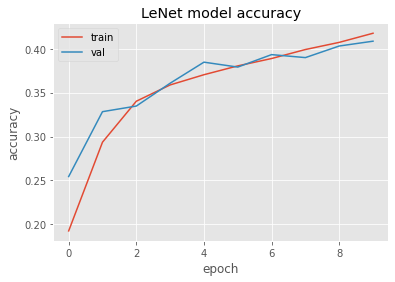

In [12]:
plt.plot(lenet_history.history['accuracy'])
plt.plot(lenet_history.history['val_accuracy'])
plt.title('LeNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

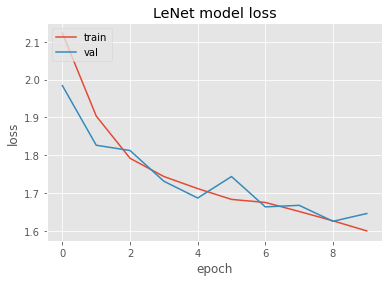

In [13]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title('LeNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Own model classification

In [14]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

Epoch 1/10
625/625 [==============================] - 28s 45ms/step - loss: 2.8622 - accuracy: 0.2589 - val_loss: 1.6395 - val_accuracy: 0.4111

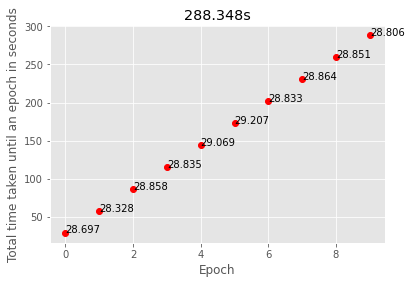

In [15]:
model_train_history = model.fit(train_img, train_labels, validation_split = 0.2, batch_size=64, epochs=10, callbacks=[timecallback()])

In [17]:
start = tf.timestamp()
model_eval = model.evaluate(test_img, test_labels, batch_size=64)
print("Seconds taken for testing: ")
print(tf.get_static_value(tf.timestamp() - start))
print("Accuracy for testing:")
print(str(round(model_eval[1] * 100,2)) + "%")

157/157 [==============================] - 2s 12ms/step - loss: 1.0201 - accuracy: 0.6492

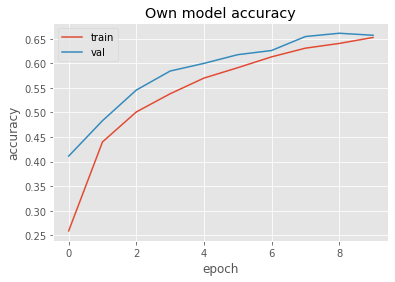

In [18]:
plt.plot(model_train_history.history['accuracy'])
plt.plot(model_train_history.history['val_accuracy'])
plt.title('Own model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

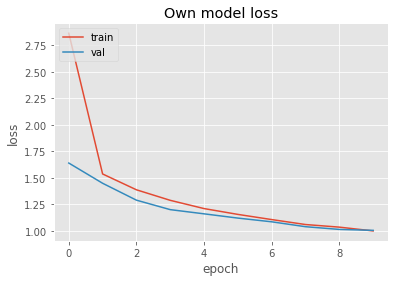

In [19]:
plt.plot(model_train_history.history['loss'])
plt.plot(model_train_history.history['val_loss'])
plt.title('Own model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ResNet classification

Epoch 1/10
625/625 [==============================] - 319s 501ms/step - loss: 1.3893 - accuracy: 0.5481 - val_loss: 1.1939 - val_accuracy: 0.5775

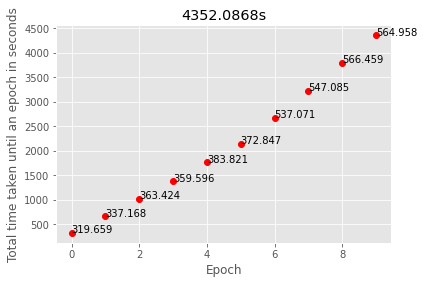

In [20]:
resnet.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
resnet_history = resnet.fit(train_img, train_labels, validation_split = 0.2, batch_size=64, epochs=10, callbacks=[timecallback()])

In [21]:
start = tf.timestamp()
resnet_eval = resnet.evaluate(test_img, test_labels, batch_size=64)
print("Seconds taken for testing: ")
print(tf.get_static_value(tf.timestamp() - start))
print("Accuracy for testing:")
print(str(round(resnet_eval[1] * 100,2)) + "%")

157/157 [==============================] - 72s 456ms/step - loss: 1.8762 - accuracy: 0.5966

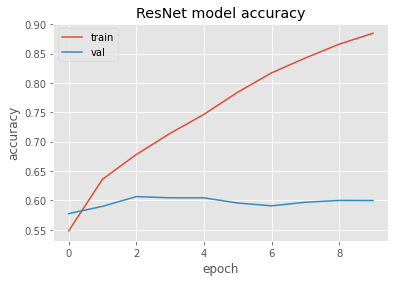

In [22]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

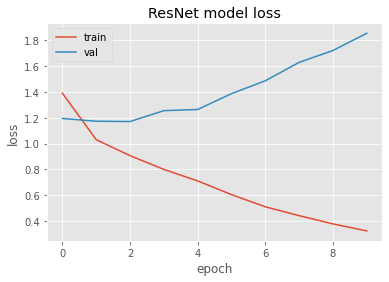

In [23]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# All model comparison

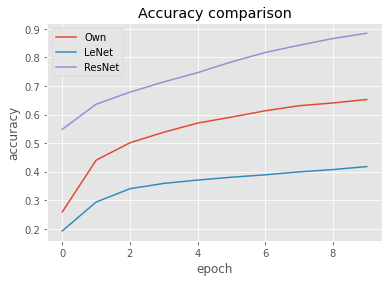

In [25]:
plt.plot(model_train_history.history['accuracy'])
plt.plot(lenet_history.history['accuracy'])
plt.plot(resnet_history.history['accuracy'])
plt.title('Accuracy comparison')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Own', 'LeNet', 'ResNet'], loc='upper left')
plt.show()

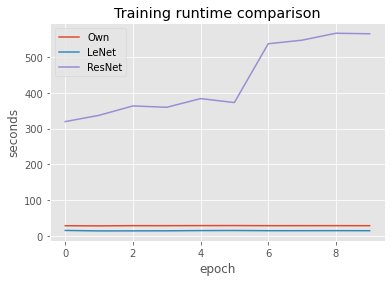

In [26]:
plt.plot(model_runtimes)
plt.plot(lenet_runtime)
plt.plot(resnet_runtimes)
plt.title('Training runtime comparison')
plt.ylabel('seconds')
plt.xlabel('epoch')
plt.legend(['Own', 'LeNet', 'ResNet'], loc='upper left')
plt.show()

In [27]:
import pandas as pd
import seaborn as sns

testing = pd.DataFrame(columns=["model", "runtime"])
testing = testing.append(pd.DataFrame([{"model": "own", "runtime": 2.0208511352539062}], index=['1'],columns=testing.columns))
testing = testing.append(pd.DataFrame([{"model": "lenet", "runtime": 1.3369569778442383}], index=['1'],columns=testing.columns))
testing = testing.append(pd.DataFrame([{"model": "resnet", "runtime": 71.67863011360168}], index=['1'],columns=testing.columns))

<AxesSubplot:xlabel='model', ylabel='runtime'>

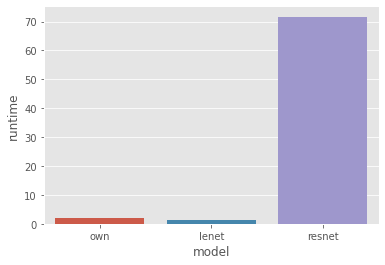

In [28]:
sns.barplot(data=testing, x="model", y="runtime")
